# Distances, thresholds, and labels in images

<img src="http://i.dailymail.co.uk/i/pix/2011/05/08/article-1384887-0886344C000005DC-438_468x286.jpg">

In [31]:
%matplotlib inline
from skimage import io, draw, color, measure
import skimage.data, skimage.filters, skimage.io, skimage.draw
from skimage.io import imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

## Distances between vectors

Color images are represented as tensors (3-dimensional arrays), and each color pixel is a vector. When we are manipulating pixels, we are really performing vector operations. 

We'll begin by reviewing the concept of distance in vector space. Here are four vectors in 2-dimensional space.

In [32]:
vectors_2d = np.array([(1, 1), (0, 1), (.5, .5), (-1, -1)])
D = pd.DataFrame(vectors_2d, columns=['x', 'y'])
D

,x,y
0,1.0,1.0
1,0.0,1.0
2,0.5,0.5
3,-1.0,-1.0


/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


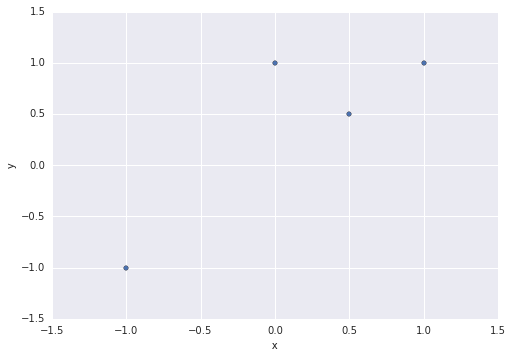

In [33]:
D.plot(kind='scatter', x='x', y='y');

### Measures of distance

In [34]:
from scipy.spatial.distance import cdist

`cdist` is a function that calculates all pairwise distances between two sets of vectors $A$ and $B$. 

The function returns the distances in a matrix with dimensions $|A| \times |B|$. Each row displays the distances of a vector in $A$ to all vectors in $B$.

In [37]:
origin_vector = np.array([0, 0]).reshape(1, -1)
distances = cdist(origin_vector, vectors_2d)
print(distances.shape)
print(distances)

(1, 4)
[[ 1.41421356  1.          0.70710678  1.41421356]]


In [38]:
D['euclidean'] = cdist(origin_vector, vectors_2d, 'euclidean').ravel()
D

,x,y,euclidean
0,1.0,1.0,1.414214
1,0.0,1.0,1.000000
2,0.5,0.5,0.707107
3,-1.0,-1.0,1.414214


In [8]:
D['cityblock'] = cdist(origin_vector, vectors_2d, 'cityblock').ravel()
D

,x,y,euclidean,cityblock
0,1.0,1.0,1.414214,2
1,0.0,1.0,1.000000,1
2,0.5,0.5,0.707107,1
3,-1.0,-1.0,1.414214,2


#### Minkowski distance (generalization)

The Minkowski distance is paramameterized by $p$. When $p=1$ it is cityblock distance. When $p=2$ it is Euclidean distance.

$$\left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p}$$


In [9]:
D['L1'] = cdist(origin_vector, vectors_2d, 'minkowski', p=1).ravel()
D['L2'] = cdist(origin_vector, vectors_2d, 'minkowski', p=2).ravel()
D

,x,y,euclidean,cityblock,L1,L2
0,1.0,1.0,1.414214,2,2,1.414214
1,0.0,1.0,1.000000,1,1,1.000000
2,0.5,0.5,0.707107,1,1,0.707107
3,-1.0,-1.0,1.414214,2,2,1.414214


Many more distance functions are described in the documentation for [cdist](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html).

### Distance images and thresholding

The nice sports car in the picture is painted in a pleasing red color. 

In [42]:
sns.set_style("white")

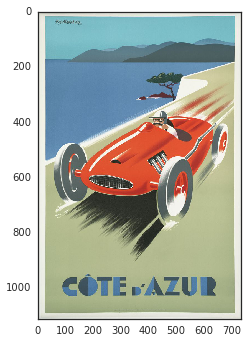

In [45]:
car_image = io.imread("cote_dazur.jpg")
car_image = skimage.img_as_float(car_image)
imshow(car_image);

Well, actually the car is not uniformly red, but has a wide range of red shades. Despite this, humans effortlessly recognize which pixels are red-ish and which aren't. Fortunately, we can use the concept of distance in color space to extend this capability to computers.

Case in point: Zooming in on a 50 by 50 patch of the image, it's clear that it consists of different red colors. 

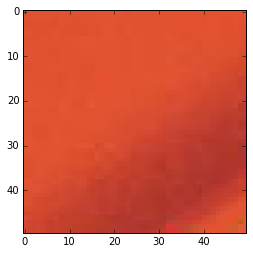

In [11]:
red_car_zoom = car_image[450:500, 400:450]
imshow(red_car_zoom)

### Distance to average red

Get the average color in this patch

/Users/anders/anaconda/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "
/Users/anders/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


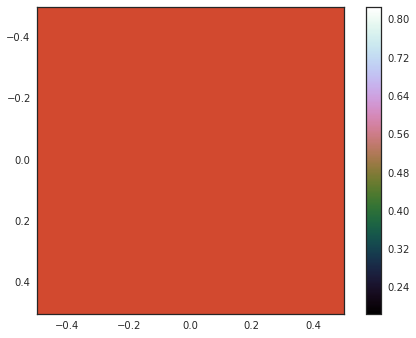

In [46]:
average_red = np.array([red_car_zoom[:,:,0].mean(), red_car_zoom[:,:,1].mean(), red_car_zoom[:,:,2].mean()])
imshow(average_red.reshape(1, 1, 3));

Calculate the distance between this red color and all the pixels of the image

In [47]:
distances = cdist(average_red.reshape(1, 3), car_image.reshape(-1, 3))
distances.shape

(1, 817696)

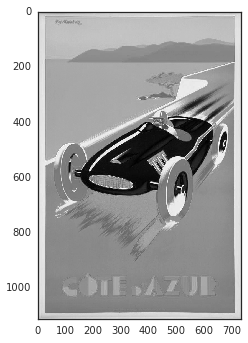

In [51]:
distance_img = distances.reshape(car_image.shape[0], car_image.shape[1])
# Convert into the range (0, 1)
distance_img /= distance_img.max()
imshow(distance_img)

The greyscale image indicates the degree of redness of each pixel. We can take a firm stand on the redness issue by applying a threshold on the greyscale image, saying, for instance, that every pixel with a distance of less than $.4$ to the average red is to be considered red. 

The result of applying the threshold is a binary image, sometimes called a mask.



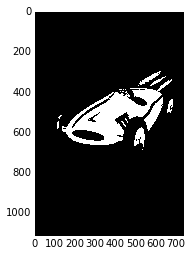

In [15]:
imshow(distance_img < 0.4)

Finding a good threshold may require experimentation

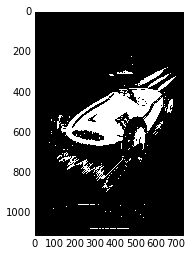

In [16]:
imshow(distance_img < 0.5)

Extract image pixels from the original image using the mask

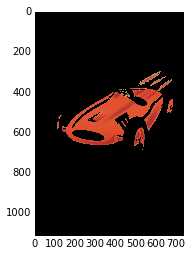

In [17]:
blank_image = np.zeros_like(car_image)
mask = distance_img < 0.4
blank_image[mask] = car_image[mask]
imshow(blank_image)

### Labeling components

*Labeling* means assigning identifiers to contigious groups of pixels in an image. Given a labeling, we can treat each component in isolation, instead of operating on the whole image. 

The concept of contigious groups is related to connected components in graphs, which we will return to in a couple of weeks. 


Here are a couple of shapes drawn on a binary image. But how many

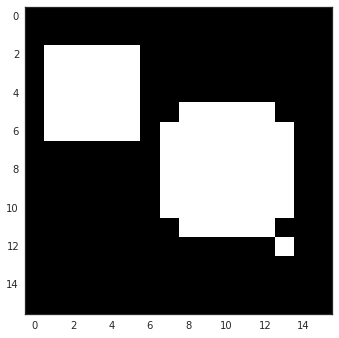

In [53]:
canvas = np.zeros((16, 16))
rr, cc = draw.circle(4, 3, 3)
canvas[rr, cc] = 1

rr, cc = draw.circle(8, 10, 4)
canvas[rr, cc] = 1

canvas[12, 13] = 1

imshow(canvas);

In [54]:
regions, n_regions = measure.label(canvas, background=0, return_num=True)
print("Number of regions", n_regions)
regions

Number of regions 2


array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

### 4-connectivity vs. 8-connectivity


In [56]:
# Using 4-connectivity
regions, n_regions = measure.label(canvas, background=0, return_num=True, neighbors=4)
print("Number of regions", n_regions)
regions

Number of regions 3


array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
       [-1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

Finally, labeled matrices may be converted into color images for visual inspection of the result.  

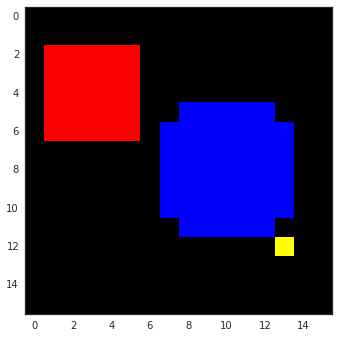

In [62]:
imshow(color.label2rgb(regions))